In [1]:
# import libraries
import os
import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from pyspark.sql import Window
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator, Evaluator
from pyspark.sql.types import IntegerType, ArrayType, FloatType, DoubleType, Row, DateType
from pyspark.ml.linalg import DenseVector, SparseVector
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import  MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession.builder.master('local[*]').appName("Sparkiify").getOrCreate()
spark

In [3]:
# Check Spark configuration
spark.sparkContext.getConf().getAll()

[('spark.driver.extraJavaOptions',
  '-XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED'),
 ('spark.sql.warehouse.dir',
  'file:/C:/Users/zanin/OneDrive/Área%20de%20Trabalho/UDACITY/Sparkfy/scored_json1/spark-warehouse'),
 ('spark.executor.id', 'driver'),
 ('spark.app.name', 'Sparkiify'),
 ('spark.driver.port', '64100'),
 

In [4]:
path = './part-00000-f1bd9623-7790-46fe-a059-d85c0054fba8-c000.json'
path_1 = './part-00001-f1bd9623-7790-46fe-a059-d85c0054fba8-c000.json'
path_2 = './part-00002-f1bd9623-7790-46fe-a059-d85c0054fba8-c000.json'
path_3 = './part-00003-f1bd9623-7790-46fe-a059-d85c0054fba8-c000.json'
final_df = spark.read.json(path)
df1 = spark.read.json(path_1)
df2 = spark.read.json(path_2)
df3 = spark.read.json(path_3)


In [5]:
# Union the dataframes
final_df = final_df.union(df1).union(df2).union(df3)
final_df.printSchema()

root
 |-- dense_vector: struct (nullable = true)
 |    |-- type: long (nullable = true)
 |    |-- values: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |-- label: long (nullable = true)
 |-- probability: struct (nullable = true)
 |    |-- type: long (nullable = true)
 |    |-- values: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |-- rawPrediction: struct (nullable = true)
 |    |-- type: long (nullable = true)
 |    |-- values: array (nullable = true)
 |    |    |-- element: double (containsNull = true)



In [10]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

get_first_val = udf(lambda x: x[0], DoubleType())
df_final = final_df.select(get_first_val("dense_vector.values").alias("dense_vector"), 
               get_first_val("probability.values").alias("probability"), 
               get_first_val("rawPrediction.values").alias("rawPrediction"),
               'label')

In [11]:
df_final = df_final.drop("dense_vector")


In [12]:
df_final = df_final.toPandas()

In [15]:
df_final.head()

,probability,rawPrediction,label
0,0.883604,66.270297,0
1,0.321663,24.124708,0
2,0.941175,70.588115,0
3,0.966985,72.523880,0
4,0.943520,70.763986,0


In [24]:
def RankScore(input_score_df, nm_score, targetname, bins):
    input_score_df['score'] = input_score_df[nm_score]
    input_score_df['rank'] = pd.cut(input_score_df[nm_score], bins, labels=False)
    df7 = input_score_df.groupby('rank').agg({targetname: np.mean, 'rank' : np.size})
    df7['id_ranks'] = df7.index
    df7['event_tx'] = df7[targetname]
    df7['qt_rank'] = df7['rank']
    df7 = df7.drop(['rank', targetname], axis= 1)
    df7 = df7.reset_index()
    df_ord_score = df7.drop(['rank'], axis= 1)
    return df_ord_score.sort_values(by='event_tx', ascending=True)

In [18]:
df_rank = RankScore(df_final, 'probability', 'label', bins=5)

In [19]:
df_rank

,id_ranks,tx_evento,qt_rank
4,4,0.000000,153
3,3,0.125000,16
2,2,0.545455,11
1,1,0.956522,23
0,0,1.000000,22


Text(0.5, 1.0, 'Score Sorting')

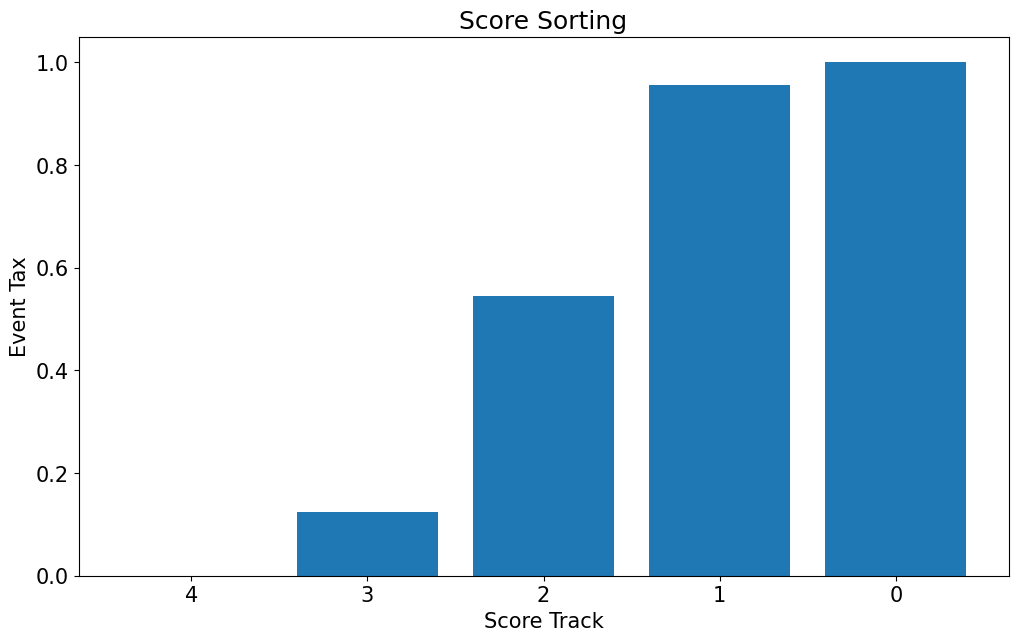

In [22]:
# sort the dataframe by column 'tx_evento' in descending order
df_rank = df_rank.sort_values(by='tx_evento', ascending=True)

height = df_rank.tx_evento
bars = df_rank.id_ranks
y_pos = np.arange(len(bars))

plt.figure(figsize=(12,7))
plt.rcParams.update({'font.size': 15})

# create bars
plt.bar(y_pos, height)

# create names on the x-axis
plt.xticks(y_pos, bars)

# setting label of y-axis
plt.ylabel('Event Tax')

# setting label of x-axis
plt.xlabel('Score Track')
plt.title('Score Sorting')